In [2]:
import numpy as np
import matplotlib.pyplot as plt

from tenpy.models.model import CouplingModel, MPOModel
from tenpy.models.lattice import Chain
from tenpy.networks.site import BosonSite
from tenpy.tools.params import asConfig

Number of sites in the Unit Cell: 1


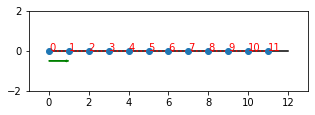

In [6]:
#PLOT THE LATTICE TO HELP VISUALIZATION

s = BosonSite(Nmax=2, conserve=None, filling=3/4) 
lat = Chain(L=12, site=s, bc='periodic') 
print("Number of sites in the Unit Cell:", lat.Lu)

plt.figure(figsize=(5, 6))
ax = plt.gca()
lat.plot_coupling(ax)                #red lines: nearest-neighbor interaction
lat.plot_order(ax, linestyle=':')    #useless for my case
lat.plot_sites(ax)                   #blue dots: sites
lat.plot_basis(ax, origin=(0,-0.5))  #green arrow
ax.set_aspect('equal')
ax.set_xlim(-1,13)
ax.set_ylim(-2,2)
plt.show()

In [7]:
class HardCoreBosonModel(CouplingModel,MPOModel):
    
    def __init__(self, model_params):
    
        # 0) read out/set default parameters
        model_params = asConfig(model_params, "BoseModel")
        
        L = model_params.get('L', 12)                 #length of the chain
        t = np.asarray(model_params.get('t', 1.))     #tunnelling rate
        rc = model_params.get('rc', 1.)               #range of soft-shoulder interaction
        V = np.asarray(model_params.get('V', 1.))     # soft-shoulder interaction
        bc_MPS = model_params.get('bc_MPS', 'finite') #boundary condition of MPS
        filling = model_params.get('filling', 0.5)    #average site filling 
        n_max = model_params.get('n_max', 1)          #max number of bosons per site
        conserve = model_params.get('conserve', 'N')  
        
        
        # 3) local physical site
        site = BosonSite(Nmax=n_max, conserve=conserve, filling=filling)
        
        # 4) lattice #ARE THESE PARAMETERS OK?
        bc = 'open' if bc_MPS == 'finite' else 'periodic'
        lat = Chain(L, site, bc=bc, bc_MPS=bc_MPS)
        
        # 5) initialize CouplingModel
        CouplingModel.__init__(self, lat)
        
        
        # 6) add terms of the Hamiltonian
        
        #NEAREST NEIGHBOR INTERACTION 
        for u1, u2, dx in self.lat.pairs['nearest_neighbors']:
            self.add_coupling(-t, u1, 'Bd', u2, 'B', dx, plus_hc=True)
            
        #SOFT SHOULDER INTERACTION
        for int_range in range(2,rc+1):
            (u1, u2, dx) = self.lat.find_coupling_pairs(max_dx=L, cutoff=rc).get(int_range)[0]
            self.add_coupling(V, u1, 'N', u2, 'N', dx, plus_hc=False)
        
        # 7) initialize H_MPO
        MPOModel.__init__(self, lat, self.calc_H_MPO())
    
    

In [8]:
#dictionary of model parameters from documentation
params = {
    'bc_MPS' : 'finite', #boundary conditions for MPS
    'conserve' : 'N', #what should be conserved
    'filling' : 3/4, #float, average filling
    'L' : 12,#length in the x-direction
    'n_max' : 1, #maximum number of bosons per site????
    't' : 1.,
    'V' : 1.,
    'rc': 4, #range of soft-shulder ionteraction: in this way nearest-neighbor interaction
}


#initialize the model
M = HardCoreBosonModel(params)

In [11]:
lat_pairs = M.lat.pairs

# get distances of the couplings
dist_pair = {}
for pair in lat_pairs:
    print(pair)
    dist = None
    for u1, u2, dx in lat_pairs[pair]:
        d = M.lat.distance(u1, u2, dx)
        print(u1, u2, dx, d)
        if dist is None:
            dist = d
            dist_pair[d] = pair
        else:
            assert abs(dist-d) < 1.e-14

dists = sorted(dist_pair.keys())
if len(dists) != len(lat_pairs):
    raise ValueError("no unique mapping dist -> pair")
    
print("(dist)   (pairs)")
for d in dists:
    print("{0:.6f} {1}".format(d, dist_pair[d]))
    

nearest_neighbors
0 0 [1] 1.0
next_nearest_neighbors
0 0 [2] 2.0
next_next_nearest_neighbors
0 0 [3] 3.0
(dist)   (pairs)
1.000000 nearest_neighbors
2.000000 next_nearest_neighbors
3.000000 next_next_nearest_neighbors


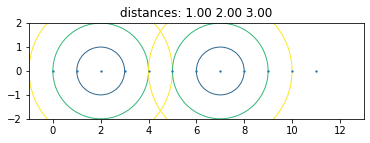

In [13]:
colors = [plt.cm.viridis(r/dists[-1]) for r in dists]
centers = np.array([[2,0], [7,0]]) # one center for each site in the unit cell
us = list(range(lat.Lu))

fig = plt.figure()
ax = plt.gca()

lat.plot_sites(ax, markersize=1.3)

for center in centers:
    for r, c in zip(dists, colors):
        circ = plt.Circle(center, r, fill=False, color=c)
        ax.add_artist(circ)

ax.set_aspect('equal')
ax.set_xlim(-1,13)
ax.set_ylim(-2,2)
t = ax.set_title("distances: " + ' '.join(['{0:.2f}'.format(d) for d in dists]))